In [1]:
%load_ext autoreload
%autoreload 2

# 0. Libraries

------------------

In [2]:
import sys
sys.path.append(r'C:\Users\Alex\git\EC-LHC\footprint\FFP_python_v1_4')
sys.path.append(r'C:\Users\Alex\git\Masters-EC-Article\source')
from calc_footprint_FFP_adjusted01 import FFP
from k15_to_raster import K15_to_raster
from initialize_analysis import InitializeAnalysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import scipy as sp
import datetime as dt
import scipy
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [4]:
import pathlib
from functools import reduce


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression

In [6]:
final_imgFolder = pathlib.Path(r"G:\Meu Drive\USP-Mestrado\Masters-Data\Imgs\Final")

# 1. Reading files

------------------

In [7]:
a = InitializeAnalysis(
    ep_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\EddyPro\2-Final-Fase01020304\EddyPro_Fase01020304",
    lf_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\Dados_Brutos\IAB3",
    iab1_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\Dados_Brutos\IAB1",
    iab2_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\Dados_Brutos\IAB2\IAB2",
    footprint_file=r"G:\Meu Drive\USP-Mestrado\Masters-Data\Footprint\classification_pixel_2018-10-05-00-30to2021-01-08-00-00_pf_80.csv",
    k15_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\Footprint\k15_process_data_v2",
    # lai_file_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\LAI\process_data\lai_reduced_k15_2020.csv",
    # # evi_file_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\EVI\processed_data\evi_reduced_k15_2020.csv"
    # # evi_file_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\EVI\processed_data\toa\evi_reduced_k15_2020.csv"
    # # evi_file_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\EVI\processed_data\sr\evi_reduced_k15_2020.csv"
    # evi_file_path=r"G:\Meu Drive\USP-Mestrado\Masters-Data\EVI\processed_data\sr\evi_reduced_mean_2020.csv"


)

Reading IAB3_EP files...
# IAB3_EP: 5	Inicio: 2018-10-05 00:30:00	Fim: 2021-01-08 00:00:00
Reading IAB3_LF files...
# IAB3_LF: 41	Inicio:2018-09-07 19:30:00	Fim: 2021-01-08 09:30:00
Reading IAB2 files...
# IAB2: 38	Inicio: 2017-02-03 09:20:00	Fim: 2021-01-22 11:30:00
Reading IAB1 files...
# IAB1: 12	Inicio: 2015-07-17 15:00:00	Fim: 2021-01-22 10:50:00
Reading Footprint file...
Inicio: 2018-10-05 00:30:00	Fim: 2021-01-08 00:00:00
Reading K15 files...
# K15: 24	Inicio: 2018-10-05 00:30:00	Fim: 2021-01-08 00:00:00
Duplicatas:  0
Verificacao de Duplicatas:  0
Duplicatas:  1
Verificacao de Duplicatas:  0
Duplicatas:  840479
Verificacao de Duplicatas:  0
Duplicatas:  507541
Verificacao de Duplicatas:  0


In [8]:
df = a.select_datetime(year=2020, 
                       # begin_hour=6, end_hour=18
                      )

In [9]:
df = df.copy()

In [10]:
df.loc[df['u*']<0.1, 'flag_basic'] = 0

In [11]:
df[['H','LE','H_strg','LE_strg']].describe()

,H,LE,H_strg,LE_strg
count,16340.000000,8697.000000,16274.000000,15732.000000
mean,39.233679,120.441086,-0.004516,-0.103232
std,93.981958,109.890856,7.855473,12.946447
min,-382.314000,0.027956,-74.262900,-185.012000
25%,-16.536900,16.139300,-4.057322,-3.292260
50%,-2.431940,104.274000,-0.472947,-0.265657
75%,72.760300,192.277000,4.234505,3.083743
max,525.850000,622.679000,49.214400,190.462000


In [12]:
df[['Rn_Avg','shf_Avg(1)','shf_Avg(2)']].describe()

,Rn_Avg,shf_Avg(1),shf_Avg(2)
count,16340.000000,16340.000000,16340.000000
mean,137.465039,-0.857813,-0.890657
std,253.245658,4.177316,4.347889
min,-152.419500,-21.610860,-16.172790
25%,-46.279508,-3.827939,-3.991867
50%,-10.490080,-1.171097,-1.288176
75%,292.147450,2.156041,2.253712
max,1053.694000,12.595790,22.547160


In [13]:
df['shf'] = df[['shf_Avg(1)','shf_Avg(2)']].mean(axis=1)

In [14]:
df['Rn-shf'] = df['Rn_Avg'] - df['shf']

In [15]:
# ,'H_strg','LE_strg'
df['EC'] = df[['H','LE','H_strg','LE_strg']].sum(axis=1)

(-200.0, 1000.0)

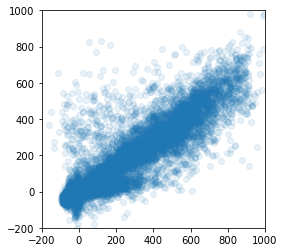

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(df['Rn-shf'], df['EC'], alpha=0.1)
plt.xlim((-200,1000))
plt.ylim((-200,1000))

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
reg = LinearRegression().fit(df['Rn-shf'].to_numpy().reshape(-1,1), df['EC'].to_numpy().reshape(-1,1))

In [19]:
reg.coef_, reg.intercept_

(array([[0.66834983]]), array([10.77578647]))

In [20]:
# .loc[df['Season']=='Spring']
df1 = df
df1 = df1[['flag_basic','flag_full','Rn-shf','EC']].dropna()

In [21]:
df_basic = df1.loc[(df['flag_basic']==True)].copy()
df_full = df1.loc[(df['flag_basic']==True)&(df['flag_full']==True)].copy()

In [22]:
reg_basic = LinearRegression().fit(df_basic['Rn-shf'].to_numpy().reshape(-1,1), 
                                   df_basic['EC'].to_numpy().reshape(-1,1))

In [23]:
reg_basic.coef_, reg_basic.intercept_

(array([[0.67926925]]), array([24.29932713]))

In [24]:
reg_full = LinearRegression().fit(df_full['Rn-shf'].to_numpy().reshape(-1,1), 
                                   df_full['EC'].to_numpy().reshape(-1,1))

In [25]:
reg_full.coef_, reg_full.intercept_

(array([[0.71556705]]), array([26.41455057]))

In [26]:
x = np.arange(-200,1000)
y = np.squeeze(x*reg_full.coef_+reg_full.intercept_)

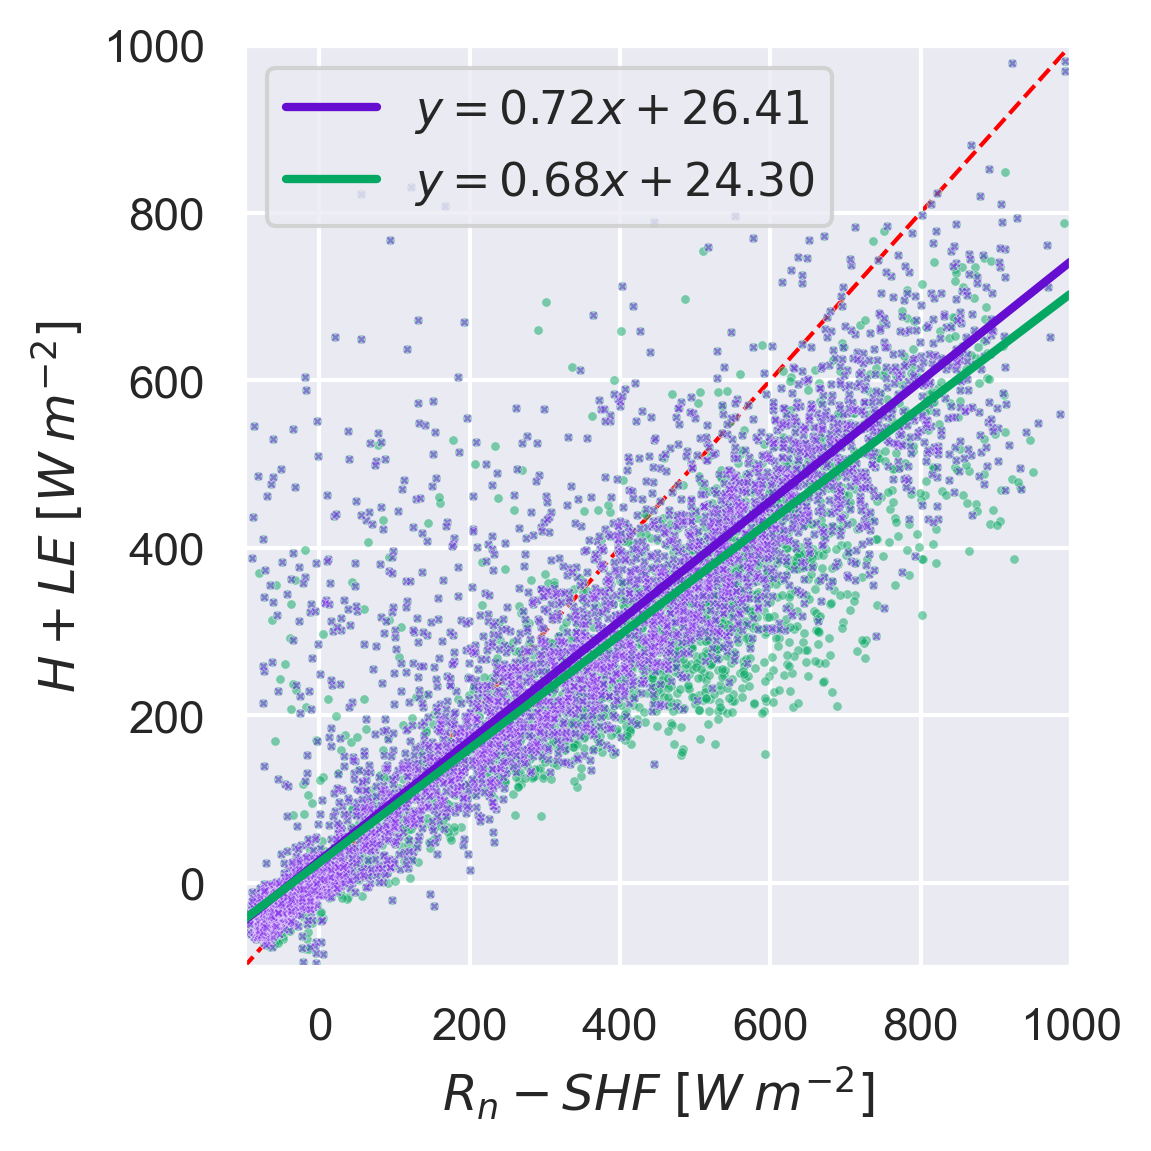

In [82]:
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
ax.plot([-200,1000], [-200,1000], color='red',linestyle='--', linewidth=1,zorder=0)


sns.scatterplot(data=df_basic,
                  x='Rn-shf', y='EC',ax=ax,
                   color=['#05a862'], s=5, alpha=0.5)

sns.scatterplot(data=df_full,
                  x='Rn-shf', y='EC',ax=ax,
                   color=['#8634eb'], s=5, alpha=0.5, marker='X')

ax.plot(x, np.squeeze(x*reg_full.coef_+reg_full.intercept_), color='#650dd1', linewidth=2, 
        label=f'$y={reg_full.coef_[0][0]:.2f}x + {reg_full.intercept_[0]:.2f}$')
ax.plot(x, np.squeeze(x*reg_basic.coef_+reg_basic.intercept_), color='#05a862', linewidth=2, 
        label=f'$y={reg_basic.coef_[0][0]:.2f}x + {reg_basic.intercept_[0]:.2f}$')

ax.set_xlim((-100,1000))
ax.set_ylim((-100,1000))

ax.set_xlabel('$R_n - SHF\; [W\: m^{-2}]$')
ax.set_ylabel('$H + LE\; [W\: m^{-2}]$')

ax.legend()
fig.tight_layout()

# fig.savefig(final_imgFolder/'FINAL-energybalance.png')